In [ ]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
from scipy.stats import norm
import scipy
import cmath


from scipy.integrate import quad

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

!rm -rf Mean-Variance-Hedging
!git clone https://github.com/chrischia06/Mean-Variance-Hedging

import sys
sys.path.append("Mean-Variance-Hedging/")
from mean_variance_hedge.dynamic_programming import *
from mean_variance_hedge.black_scholes import *
from mean_variance_hedge.utils import *

%load_ext tensorboard

!git clone https://github.com/ryanmccrickerd/rough_bergomi
sys.path.append("rough_bergomi/rbergomi")
from rbergomi import *
from utils import *
import matplotlib.pyplot as plt

Cloning into 'Mean-Variance-Hedging'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 75 (delta 22), reused 67 (delta 18), pack-reused 0
Unpacking objects: 100% (75/75), done.
Cloning into 'rough_bergomi'...
remote: Enumerating objects: 47, done.
remote: Total 47 (delta 0), reused 0 (delta 0), pack-reused 47
Unpacking objects: 100% (47/47), done.


In [ ]:
####################
#    PARAMETERS    #
####################

S0 = 100 
K_strike = 100
N_SAMPLES = 10 ** 5
T = 30
dt = 1/250
r = 0
rf = np.exp(r * dt)
CALL = 1

#Generate Sample rough bergomi paths 

Generate Sample rough bergomi pathsusing the turbocharged scheme from: https://github.com/ryanmccrickerd/rough_bergomi

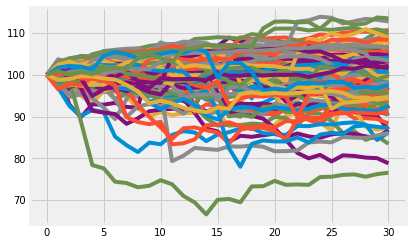

In [ ]:
np.random.seed(2021) # set random seed

rB = rBergomi(n = 250, N = N_SAMPLES, T = T * dt, a = -0.43)
dW1 = rB.dW1()
dW2 = rB.dW2()
Y = rB.Y(dW1)
dB = rB.dB(dW1, dW2, rho = -0.9)
V = rB.V(Y, xi = 0.235**2, eta = 1.9)
Sts = S0 * rB.S(V, dB)

# plot sample paths
plt.plot(Sts[:100,:].T);

# Calibrate Black-Scholes

In [ ]:
vec_bsinv = np.vectorize(bsinv)
MC_price = np.mean(np.maximum(Sts[:,T] - K_strike ,0))
imp_vol = bsinv(price=MC_price, St=S0, K=K_strike, r = r, tau = T * dt, flag = 1)

tis = np.arange(T + 1) #0, 1 .. T
tis = np.tile(tis, N_SAMPLES).reshape(N_SAMPLES, T + 1) # [[0, 1.. T], [0, 1.. T]...]

print(MC_price, imp_vol)

2.8832261981265574 0.20867603521939726


# Calibrate Dynamic Programming Lattice

[-0.071  0.061]
Log-return space [-0.064, -0.051, -0.038, -0.025, -0.012, 0.002, 0.015, 0.028, 0.041, 0.054]
Dynamic Hedge Price 3.391092965276773


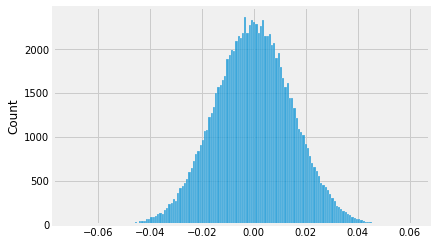

In [ ]:
observed_rets = np.log(Sts[:,1] / Sts[:,0])
fig, ax = plt.subplots()
sns.histplot(observed_rets, ax=ax)
bounds = np.round([observed_rets.min(), observed_rets.max()], 3)
print(bounds)

scale_factor = 10 ** 3

N_discrete_states = 10
bins = np.linspace(bounds[0], bounds[1], N_discrete_states + 1)
counts, val = np.histogram(observed_rets, bins=bins)
p_probs = counts / np.sum(counts)

log_ret_space = [round((bins[i] + bins[i + 1]) / 2, 3) for i in range(len(bins) - 1)]
log_ret_space2 = [round(x * scale_factor) for x in log_ret_space]
ret_space = np.exp(log_ret_space) # returns
a, b, m, q_probs = calc_variance_optimal_measure(ret_space, rf, p_probs)
print("Log-return space",log_ret_space)

attainable_nodes = possible_nodes(log_ret_space, T, scale_factor)
Hts = calc_mean_value_process(attainable_nodes, S0, K_strike, rf, log_ret_space, T, scale_factor, q_probs)
dynamic_delta = calc_dynamic_deltas(attainable_nodes, Hts, S0, rf, log_ret_space, T, scale_factor, q_probs)    
print("Dynamic Hedge Price", Hts[0][0])

# Calculate Hedges for Black Scholes, Dynamic Programming approaches

In [ ]:
%%time

bs_vals = np.zeros((N_SAMPLES, T + 1))
dynamic_vals = np.zeros((N_SAMPLES, T + 1))
local_vals = np.zeros((N_SAMPLES, T + 1))




bs_vals[:,0] = MC_price
dynamic_vals[:,0] = MC_price
local_vals[:,0] = MC_price

bs_deltas = np.zeros((N_SAMPLES, T))
dynamic_deltas = np.zeros((N_SAMPLES, T ))
local_deltas = np.zeros((N_SAMPLES, T ))

dynamic_deltas[:, 0] = dynamic_delta[0][0]
local_deltas[:,0] = dynamic_delta[0][0] + rf * a * (Hts[0][0] - MC_price) / S0

attainable_rets = {t:np.array(list(attainable_nodes[t])) for t in range(T + 1)}

for i in range(N_SAMPLES):
  for t in range(1, T):
    current_node = attainable_rets[t][np.abs(attainable_rets[t] - (np.log(Sts[i,t] / S0) * scale_factor)).argmin()]
    dynamic_deltas[i, t] = dynamic_delta[t][current_node]
    # adjustment require for the locally-optimal hedging value
    local_vals[i, t] = (rf * local_vals[i, t - 1] + 
                        local_deltas[i, t - 1] * 
                        (Sts[i, t] - rf * Sts[i, t - 1]))
    local_deltas[i, t] = (dynamic_delta[t][current_node] + 
                         rf * a * (Hts[t][current_node] - local_vals[i, t]) / Sts[i, t])
  local_vals[i, T] = (rf * local_vals[i, T - 1] + 
                      local_deltas[i, T - 1] * 
                      (Sts[i, T] - rf * Sts[i, T - 1]))
    
    
for i in range(N_SAMPLES):
  bs_deltas[i, :] = delta(Sts[i, :-1], K_strike, r, imp_vol, (T - tis[i,:-1]) * dt, CALL) # BS deltas

for t in range(1, T + 1):
  bs_vals[:, t] = rf * bs_vals[:, t - 1] + bs_deltas[:, t  - 1] * (Sts[:, t] - rf * Sts[: , t- 1])
  dynamic_vals[:, t] = rf * dynamic_vals[:, t - 1] + dynamic_deltas[:, t  - 1] * (Sts[:, t] - rf * Sts[: , t- 1])

# calculate terminal value = hedging portfolio value - (ST - K)+
bs_terminal_error = bs_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)  
local_terminal_error = local_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)  
dynamic_terminal_error = dynamic_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)  

CPU times: user 50.9 s, sys: 19.5 ms, total: 50.9 s
Wall time: 51.1 s


# Deep Hedging

+ Generate a second collection of 5000 sample paths < 10000
+ Use only moneyness as feature

In [ ]:
from sklearn.model_selection import train_test_split
# true sample paths
X_true = np.log(Sts[:,:-1] / K_strike)
X_true = X_true.reshape((-1, T, 1))
y_true = Sts.reshape((-1, T + 1, 1))

# generate additional paths
np.random.seed(42)
TRAIN_PATHS = 10 ** 5
rB2 = rBergomi(n = 250, N = TRAIN_PATHS, T = T * dt, a = -0.43)
dW12 = rB2.dW1()
dW22 = rB2.dW2()
Y2 = rB2.Y(dW12)
dB2 = rB2.dB(dW12, dW22, rho = -0.7)
V2 = rB2.V(Y2, xi = 0.235**2, eta = 1.9)
Sts2 = S0 * rB2.S(V2, dB2)

# training data
X = np.log(Sts2 / K_strike)
n_feats = 1
X2 = X[:, :-1].reshape((-1, T, n_feats))
y2 = Sts2.reshape((-1, T + 1, n_feats))

X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.2, random_state = 42)

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

def deep_hedger(T, n_feats):
    """
    Feed-Forward Neural Network
    """
    input_layer = Input(shape = (None, n_feats))
    # batch_norm = BatchNormalization()(input_layer)
    layer_1 = GRU(32, activation='tanh', 
                      kernel_initializer=initializers.RandomNormal(0,0.1),
                      bias_initializer=initializers.RandomNormal(0,0.1),
                  return_sequences=True
                  )(input_layer)
    # layer_2 = Dense(16, activation='relu',
    #                 kernel_initializer=initializers.RandomNormal())(batch_norm1)
    # batch_norm2 = BatchNormalization()(layer_2)
    # layer_3 = Dense(8, activation='relu', 
    #                 kernel_initializer = initializers.RandomNormal())(batch_norm2)
    # batch_norm3 = BatchNormalization()(layer_3)
    output_layer = Dense(1, activation='linear',
                         kernel_initializer=initializers.RandomNormal(),
                         bias_initializer=initializers.RandomNormal(0,0.1)
                         )(layer_1)
    model = Model(input_layer, output_layer)
    return model



In [ ]:
def MSHE_Loss(init_price, strike, T):
    def lossFunction(y_true,y_pred):
      # for simplcity ignore rf for now, although this could be incorporated
      price_changes = tf.experimental.numpy.diff(y_true, n=1, axis=1)
      val = tf.reduce_sum(tf.math.multiply(price_changes, y_pred),axis=1)
      # print(tf.shape(price_changes))     
      # print(tf.shape(y_true)Z)
      option_val = tf.math.maximum(y_true[:,-1] - strike, 0)

      # val = (tf.math.reduce_sum(deltas * price_changes,axis=1))
      return tf.math.reduce_mean(tf.math.square(-option_val + val + init_price))
    return lossFunction

def cvarLoss(init_price, strike, T, batch_size, proportion = 0.01):
    num = int(batch_size * proportion)
    def lossFunction(y_true,y_pred):
      price_changes = tf.experimental.numpy.diff(y_true, n=1, axis=1)
      val = tf.reduce_sum(tf.math.multiply(price_changes, y_pred),axis=1)      
      option_val = tf.math.maximum(y_true[:,-1,:] - strike, 0)
      # top k worse - net value
      error = tf.reshape(-(-option_val + val + init_price), [-1])
      CVaR, idx = tf.math.top_k(error, tf.constant(num, dtype=tf.int32))
      # return tf.math.reduce_mean(CVaR)
      return tf.math.reduce_mean(CVaR)
    return lossFunction

In [ ]:
import os
import datetime
tf.random.set_seed(2021)

####################
#    DNN PARAMS    #
####################
lr = 0.005
BATCH_SIZE = 256
EPOCHS = 50


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_callback =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = deep_hedger(T, n_feats)
model.summary()
print("Check Model", model.predict(np.zeros((1, T, 1))).reshape(-1))

mshe_loss = MSHE_Loss(init_price=MC_price, strike=K_strike, T = T)
model.compile(optimizer=Adam(learning_rate=lr), loss=mshe_loss)
model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, 
          batch_size=BATCH_SIZE, callbacks=[tensorboard_callback,early_stopping_callback],
          validation_data=(X_val, y_val), shuffle=False)

# cvar_loss = cvarLoss(init_price = MC_price, strike = K_strike, T = T, batch_size = BATCH_SIZE, proportion = 0.01)

# cvar_model = deep_hedger(T, n_feats)
# cvar_model.compile(optimizer=Adam(learning_rate=lr), loss=cvar_loss)
# cvar_model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, 
#           batch_size=BATCH_SIZE, callbacks=[tensorboard_callback,early_stopping_callback],
#           validation_data=(X_val, y_val), shuffle=False)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
gru (GRU)                    (None, None, 32)          3360      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________
Check Model [-0.02293535 -0.00704249  0.00108805  0.00526644  0.00739373  0.00844738
  0.00894241  0.00915322  0.00922545  0.00923493  0.00921978  0.00919808
  0.00917754  0.00916084  0.00914831  0.00913939  0.00913328  0.00912921
  0.00912657  0.0091249   0.00912386  0.00912324  0.00912286  0.00912265
  0.00912253  0.00912246  0.00912243  0.00912242  0.00912242  0.00912242]
Epoch 1/50


In [ ]:
## Pre calculate deep hedges

deep_hedge_deltas = np.zeros((N_SAMPLES, T))
deep_cvar_hedge_deltas = np.zeros((N_SAMPLES, T))

for i in range(T):
  temp= model.predict(X_true[:,:(i + 1),:], batch_size=512)
  deep_hedge_deltas[:,i] =  temp.reshape(-1, i + 1)[:,i]
  # temp2 = cvar_model.predict(X_true[:,:(i + 1),:], batch_size=512)
  # deep_cvar_hedge_deltas[:, i] = temp2.reshape(-1, i + 1)[:,i]

## Calculate Portolio Values
deep_vals = np.zeros((N_SAMPLES, T + 1))
deep_vals[:,0] = MC_price

deep_cvar_vals = np.zeros((N_SAMPLES, T + 1))
deep_cvar_vals[:,0] = MC_price


for t in range(1, T + 1):
    deep_vals[:, t] = rf * deep_vals[:, t - 1] + deep_hedge_deltas[:, t - 1] * (Sts[:, t] - rf * Sts[:, t - 1]) 
    # deep_cvar_vals[:, t] = rf * deep_cvar_vals[:, t - 1] + deep_cvar_hedge_deltas[:, t - 1] * (Sts[:, t] - rf * Sts[:, t - 1]) 
    

deep_terminal_error = deep_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)
# deep_cvar_terminal_error = deep_cvar_vals[:, T] - np.maximum(Sts[:, T] - K_strike, 0)

,MSHE,CVar 1%,CVaR 5%,CVar 10%,CVaR 50%
BS-delta,2.070197,8.169673,4.217173,2.999866,0.898994
Local Hedge,2.027942,7.786569,4.026755,2.905688,0.924779
Dynamic Hedge,2.025102,7.794947,4.025203,2.901891,0.923748
Deep-Hedger,1.909291,7.309345,3.845209,2.802909,0.904726


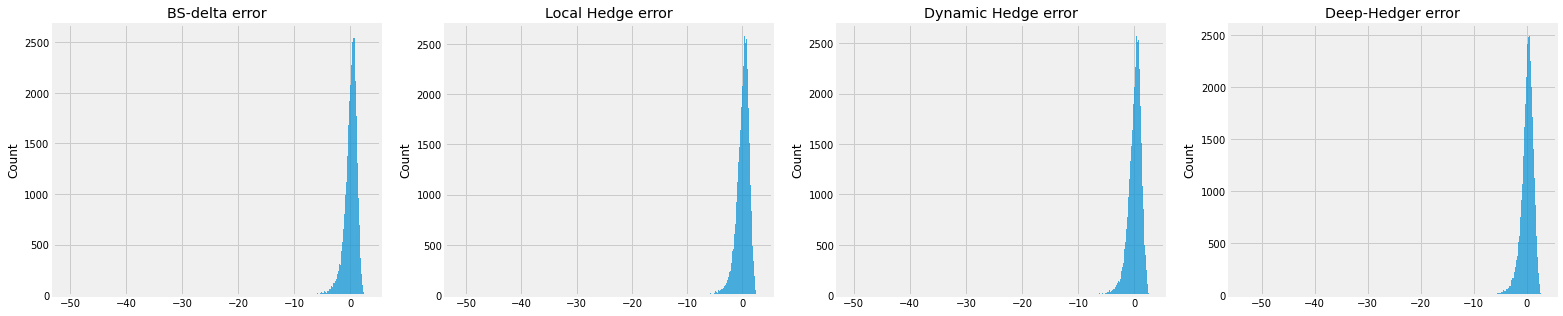

In [ ]:
hedging_errors = [bs_terminal_error, local_terminal_error, dynamic_terminal_error,
                  deep_terminal_error] #, deep_cvar_terminal_error]

hedging_errors2 = [diagnosis(error) for error in hedging_errors]
results = pd.concat(hedging_errors2)

titles = ["BS-delta", "Local Hedge", "Dynamic Hedge", ] + ["Deep-Hedger"]#, "Deep-CVaR-Hedger"]
results.index = titles
display(results)


plot_titles = [title +" error" for title in titles]
fig, ax = plt.subplots(ncols= len(titles), figsize=(len(titles) * 6, 5))
for i in range(len(titles)):
  sns.histplot(hedging_errors[i], ax=ax[i]).set_title(plot_titles[i]) 

In [ ]:
print(results.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      MSHE &   CVar 1\% &   CVaR 5\% &  CVar 10\% &  CVaR 50\% \\
\midrule
BS-delta      &  2.070197 &  8.169673 &  4.217173 &  2.999866 &  0.898994 \\
Local Hedge   &  2.027942 &  7.786569 &  4.026755 &  2.905688 &  0.924779 \\
Dynamic Hedge &  2.025102 &  7.794947 &  4.025203 &  2.901891 &  0.923748 \\
Deep-Hedger   &  1.909291 &  7.309345 &  3.845209 &  2.802909 &  0.904726 \\
\bottomrule
\end{tabular}



## Exploration of what the strategies are doing for specific paths:

7167


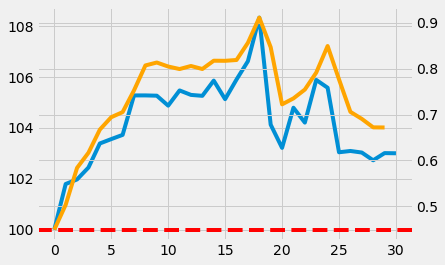

In [ ]:
i = np.random.randint(N_SAMPLES)
print(i)
fig, ax = plt.subplots()
plt.plot(np.arange(0, T + 1),  Sts[i,:].T)
ax2 = ax.twinx()
ax2.plot(np.arange(0, T), deep_hedge_deltas[i,:].T, c='orange')
ax.axhline(K_strike,linestyle="--", c='red')

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

i = np.random.randint(N_SAMPLES)
print(i)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=np.arange(0, T + 1),  y = Sts[i,:].T, name="Price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=np.arange(0, T), y= deep_hedge_deltas[i,:].T, name="Deep Hedge"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=np.arange(0, T), y= bs_deltas[i,:].T, name="Black-Scholes Hedge"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=np.arange(0, T), y= local_deltas[i,:].T, name="Local Hedge"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=np.arange(0, T), y= dynamic_deltas[i,:].T, name="dynamic"),
    secondary_y=True,
)

fig.update_layout(
    title_text="Hedging Comparison"
)


# Set x-axis title
fig.update_xaxes(title_text="Time")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Price</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Hedge Quantity</b>", secondary_y=True)

print(f"Deep PNL: {deep_terminal_error[i]}")
print(f"Black-Scholes PNL: {bs_terminal_error[i]}")
print(f"Dynamic PNL: {dynamic_terminal_error[i]}")
print(f"Local PNL: {local_terminal_error[i]}")

fig.show()

# Create fig2ure with secondary y-axis
fig2 = make_subplots(specs=[[{"secondary_y": True}]])


fig2.add_trace(
    go.Scatter(x=np.arange(0, T), y= deep_vals[i,:].T, name="Deep Hedge"),
)

fig2.add_trace(
    go.Scatter(x=np.arange(0, T), y= bs_vals[i,:].T, name="Black-Scholes Hedge"),
)

fig2.add_trace(
    go.Scatter(x=np.arange(0, T), y= local_vals[i,:].T, name="Local Hedge"),
)

fig2.add_trace(
    go.Scatter(x=np.arange(0, T), y= dynamic_vals[i,:].T, name="Local"),
)

fig2.update_layout(
    title_text="Hedging Portfolio Values"
)


# Set x-axis title
fig2.update_xaxes(title_text="Time")

# Set y-axes titles
fig2.update_yaxes(title_text="<b>Price</b>", secondary_y=False)
fig2.update_yaxes(title_text="<b>Hedge Quantity</b>", secondary_y=True)


print(f"Terminal Stock price S_T {Sts[i, -1]:.2f}")
print(f"Terminal Liability Value Z_T {np.maximum(Sts[i, -1] - K, 0):.2f}")


fig2.show()

2580
Deep PNL: 0.6644651881955098
Black-Scholes PNL: -0.036675443255525304
Dynamic PNL: 0.1772902895940764
Local PNL: 0.1798971989766423


Terminal Stock price S_T 98.24
Terminal Liability Value Z_T 0.00


In [ ]:
liability_value = np.maximum(Sts[:,-1] - K, 0)
print(f"MSHE of OOM, Deep, {np.mean(deep_terminal_error[liability_value == 0] ** 2)}")
print(f"MSHE of OOM, Black-Scholes, {np.mean(bs_terminal_error[liability_value == 0] ** 2)}")
print(f"MSHE of OOM, Dynamic, {np.mean(dynamic_terminal_error[liability_value == 0] ** 2)}")
print(f"MSHE of OOM,  Local, {np.mean(local_terminal_error[liability_value == 0] ** 2)}")


print(f"MSHE of ITM, Deep, {np.mean(deep_terminal_error[liability_value > 0] ** 2)}")
print(f"MSHE of ITM, Black-Scholes, {np.mean(bs_terminal_error[liability_value > 0] ** 2)}")
print(f"MSHE of ITM, Dynamic, {np.mean(dynamic_terminal_error[liability_value > 0] ** 2)}")
print(f"MSHE of ITM,  Local, {np.mean(local_terminal_error[liability_value > 0] ** 2)}")

print(f"Mean Error of ITM, Deep, {np.mean(deep_terminal_error[liability_value > 0])}")
print(f"Mean Error of ITM, Black-Scholes, {np.mean(bs_terminal_error[liability_value > 0])}")
print(f"Mean Error of ITM, Dynamic, {np.mean(dynamic_terminal_error[liability_value > 0])}")
print(f"Mean Error of ITM,  Local, {np.mean(local_terminal_error[liability_value > 0])}")

print(f"Mean Error of OOM, Deep, {np.mean(deep_terminal_error[liability_value == 0])}")
print(f"Mean Error of OOM, Black-Scholes, {np.mean(bs_terminal_error[liability_value == 0])}")
print(f"Mean Error of OOM, Dynamic, {np.mean(dynamic_terminal_error[liability_value == 0])}")
print(f"Mean Error of OOM,  Local, {np.mean(local_terminal_error[liability_value == 0])}")

print(np.sum(liability_value > 0))

MSHE of OOM, Deep, 3.013027908854181
MSHE of OOM, Black-Scholes, 2.2089889311741473
MSHE of OOM, Dynamic, 2.379664263581639
MSHE of OOM,  Local, 2.540831229693545
MSHE of ITM, Deep, 2.6019448551315696
MSHE of ITM, Black-Scholes, 3.742458189519086
MSHE of ITM, Dynamic, 3.203437017542899
MSHE of ITM,  Local, 3.05726442205702
Mean Error of ITM, Deep, -0.43852995755992297
Mean Error of ITM, Black-Scholes, -0.5012493797488436
Mean Error of ITM, Dynamic, -0.4266604777103684
Mean Error of ITM,  Local, -0.3985367249284809
Mean Error of OOM, Deep, -0.7670383717532492
Mean Error of OOM, Black-Scholes, -0.6657363197934174
Mean Error of OOM, Dynamic, -0.772215276755298
Mean Error of OOM,  Local, -0.8057066653817975
5607


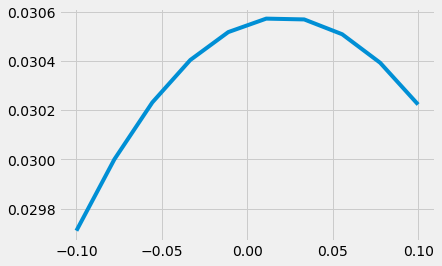

In [ ]:
# inspect NN behaviour
# partial f / partial moneyness * 1 / S
moneyness_grid = np.linspace(-0.1, 0.1, 10).reshape(-1, 1, 1)
inp = tf.Variable(moneyness_grid, dtype=tf.float32)
with tf.GradientTape() as tape:
    preds = model(inp)
grads = tape.gradient(preds, inp)


grads = grads.numpy().reshape(-1)

plt.plot(moneyness_grid.reshape(-1), grads / (K_strike * np.exp(moneyness_grid.reshape(-1))))